# Integrantes
* Tomas Acosta Bernal
* Samuel Romero

In [8]:
import cv2
import matplotlib.pyplot as plt
import pandas 
import numpy
import os

# Exploracion datos

In [9]:
ruta = "data/Imagenes/"
elementos = os.listdir(ruta)
for _ in elementos:
    print(f"Número de elementos en la carpeta {_}:", len(os.listdir(ruta + _)))

Número de elementos en la carpeta test: 372
Número de elementos en la carpeta train: 1178
Número de elementos en la carpeta val: 107


In [10]:
1178//4


294

In [11]:
294*3

882

In [12]:
train_data = os.listdir(ruta + "train")

In [13]:
len(train_data)

1178

In [14]:
train_data = train_data[:294]
len(train_data)

294

In [15]:
print(ruta+"train/"+train_data[0])

data/Imagenes/train/video_11min_001.jpg


Número óptimo de clusters según el método del codo: 11


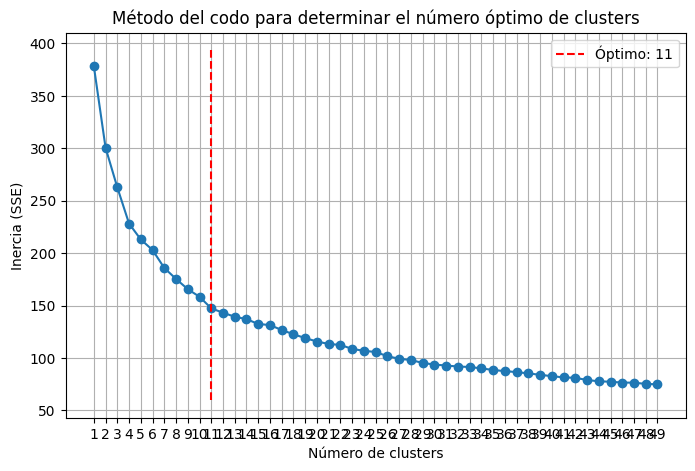

In [35]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator  # Instalar con: pip install kneed

# Directorio de imágenes y cálculo de histogramas (igual que antes)
ruta_train = "data/Imagenes/train/"
train_data = os.listdir(ruta_train)

histograms = []
nombres = []

for img_name in train_data:
    img_path = os.path.join(ruta_train, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()  
    histograms.append(hist)
    nombres.append(img_name)

histograms = np.array(histograms)

# Rango de clusters a probar, por ejemplo de 1 a 10
range_clusters = range(1, 50)
inercia = []

for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(histograms)
    inercia.append(kmeans.inertia_)

# Utilizar KneeLocator para detectar el "codo"
kneedle = KneeLocator(range_clusters, inercia, curve='convex', direction='decreasing')
optimal_k = kneedle.knee
print("Número óptimo de clusters según el método del codo:", optimal_k)

# Graficar el método del codo
plt.figure(figsize=(8,5))
plt.plot(range_clusters, inercia, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia (SSE)")
plt.title("Método del codo para determinar el número óptimo de clusters")
plt.xticks(range_clusters)
plt.grid(True)
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Óptimo: {optimal_k}')
plt.legend()
plt.show()


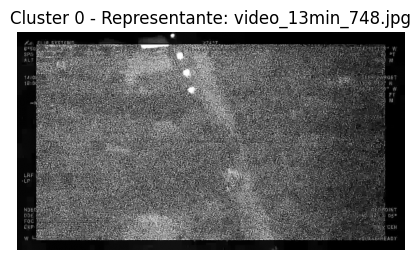

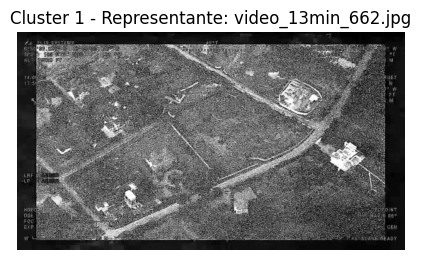

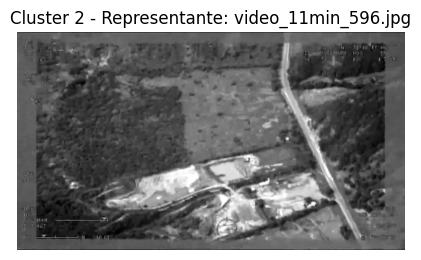

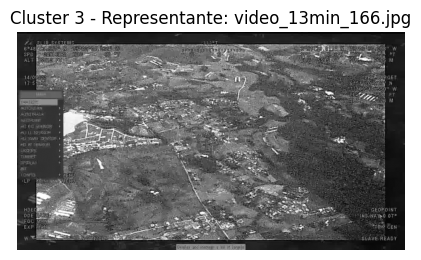

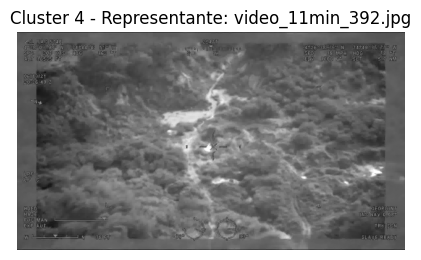

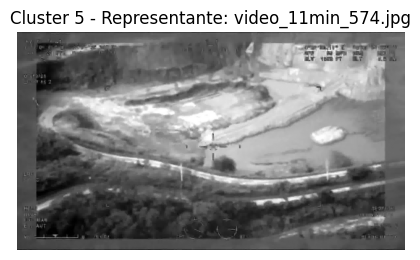

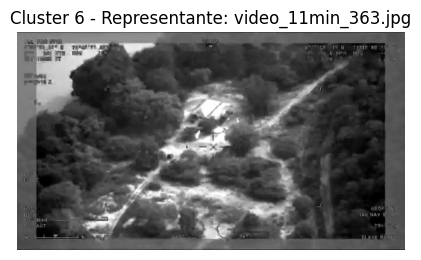

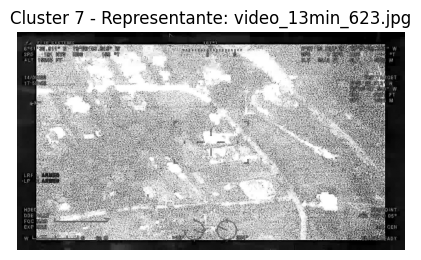

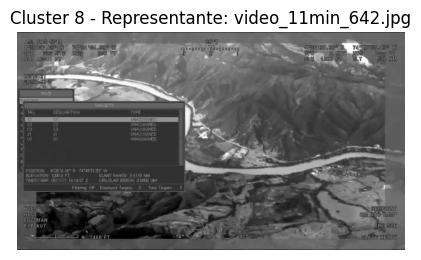

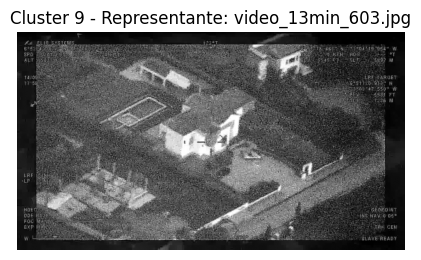

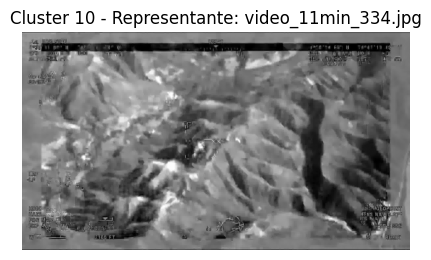

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Directorio de imágenes
ruta_train = "data/Imagenes/train/"
train_data = os.listdir(ruta_train)

histograms = []
nombres = []

for img_name in train_data:
    img_path = os.path.join(ruta_train, img_name)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    hist = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist = cv2.normalize(hist, hist).flatten()  
    histograms.append(hist)
    nombres.append(img_name)

histograms = np.array(histograms)

num_clusters = 11
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(histograms)

for cluster in range(num_clusters):
    indices = np.where(clusters == cluster)[0]
    if len(indices) == 0:
        continue
    
    cluster_histograms = histograms[indices]
    cluster_names = [nombres[i] for i in indices]
    
    centroid = kmeans.cluster_centers_[cluster]
    
    distances = [cv2.compareHist(hist, centroid, cv2.HISTCMP_BHATTACHARYYA) for hist in cluster_histograms]
    indice_min = np.argmin(distances)
    
    imagen_repr = cluster_names[indice_min]
    
    img_path = os.path.join(ruta_train, imagen_repr)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.title(f"Cluster {cluster} - Representante: {imagen_repr}")
    plt.axis("off")
    plt.show()


Segun el numero optimo de clusters podemos ver que las imagenes difieren bastante entre ellas, primero calculamos el histograma normalizado y se eligieron 11 grupos distintos que agrupaban las imagenes en esos clusters.

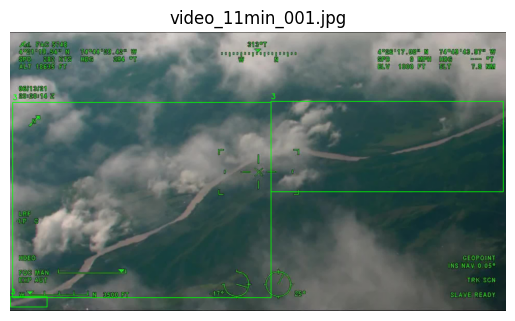

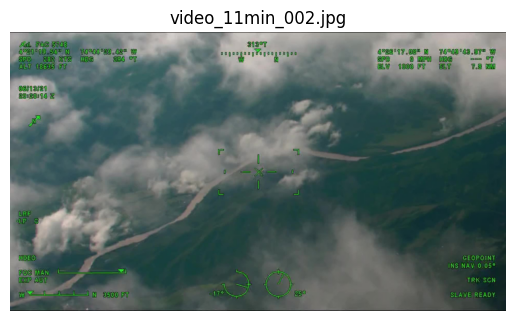

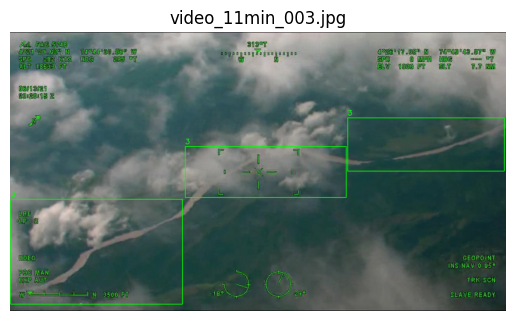

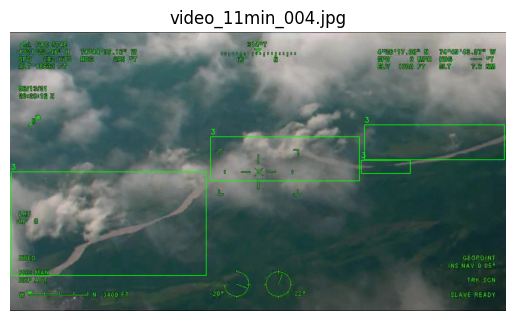

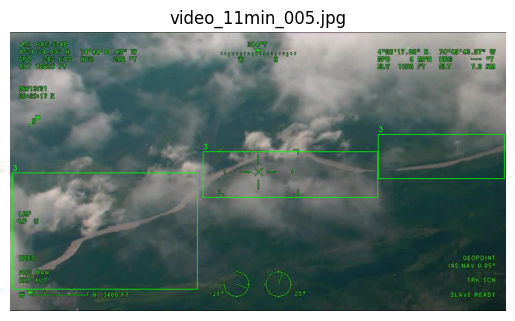

In [23]:
import os
import cv2
import matplotlib.pyplot as plt

# Directorios de imágenes y etiquetas
image_dir = "data/Imagenes/train"
label_dir = "data/Etiquetas/train"

image_files = [f for f in os.listdir(image_dir) if f.lower().endswith('.jpg')]

for image_file in image_files[:5]:
    img_path = os.path.join(image_dir, image_file)
    img = cv2.imread(img_path)
    if img is None:
        print("No se pudo leer:", img_path)
        continue

    height, width, _ = img.shape

    base_name, _ = os.path.splitext(image_file)
    label_path = os.path.join(label_dir, base_name + ".txt")
    if not os.path.exists(label_path):
        print("No existe etiqueta para:", image_file)
        continue

    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) != 5:
            print("Formato de etiqueta incorrecto en", label_path)
            continue

        class_id, x_center_norm, y_center_norm, width_norm, height_norm = map(float, parts)
        
        x_center = x_center_norm * width
        y_center = y_center_norm * height
        box_width = width_norm * width
        box_height = height_norm * height

        x1 = int(x_center - box_width / 2)
        y1 = int(y_center - box_height / 2)
        x2 = int(x_center + box_width / 2)
        y2 = int(y_center + box_height / 2)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        
        cv2.putText(img, str(int(class_id)), (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.title(image_file)
    plt.axis("off")
    plt.show()


Hay algunas imagenes muy malas, que tienen una etiqueta que a simple vista no se ve ninguna zona de mineria ilegal